<a href="https://colab.research.google.com/github/KaranSantra/ChaiBachai/blob/working-two-masks/masking_frames_from_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision==0.23.0
%pip install "ultralytics<=8.3.40"


import os
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import supervision as sv
import base64
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from enum import Enum

# Constants
HOME = os.getcwd()
!mkdir -p {HOME}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights
CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
MODEL_TYPE = "vit_h"
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

  Preparing metadata (setup.py) ... done


In [28]:
IS_COLAB = True
IMAGE_NAME = "test-1.jpg"
IMAGE_PATH = f"{HOME}/rising-tea-images/rest-1.jpg"
VIDEO_FILE = "rising-tea-2.mp4"
FRAME_COUNT = 0
MAX_FRAME_COUNT = 50

class Color(Enum):
    # Convert numpy arrays to tuples which can be properly compared
    RED = (1.0, 0.0, 0.0)
    GREEN = (0.0, 1.0, 0.0)
    YELLOW = (1.0, 1.0, 0.0)
    BLUE = (0.0, 0.0, 1.0)

    def to_array(self):
        return np.array(self.value)


In [3]:
mask_generator = SamAutomaticMaskGenerator(sam,
        # points_per_side= 16,
        # points_per_batch = 64,
        # pred_iou_thresh=0.55,
        # stability_score_thresh=0.75,
        # stability_score_offset=1.0,
        # box_nms_thresh = 0.7,
        # crop_n_layers = 0,
        # crop_nms_thresh = 0.7,
        # crop_overlap_ratio = 512 / 1500,
        # crop_n_points_downscale_factor= 1,
        # point_grids = None,
        # min_mask_region_area = 0
                                           )


In [29]:
!rm -rf frames

In [30]:
def extract_frames(video_path, output_dir):
    """Extract frames from video at 1-second intervals and save them to output directory"""
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = 0
    save_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        # Save frame if it corresponds to a second mark (based on FPS)
        if frame_count % int(fps) == 0 and save_count < MAX_FRAME_COUNT:
            frame_path = os.path.join(output_dir, f"frame-{save_count:04d}.jpg")
            cv2.imwrite(frame_path, frame)
            save_count += 1
        frame_count += 1
    cap.release()
    global FRAME_COUNT
    FRAME_COUNT = save_count
    return

In [31]:
# helper function that loads an image before adding it to the widget
import base64
def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded
if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()
from jupyter_bbox_widget import BBoxWidget
# extract frames from video (named "rising-tea-video.mp4") into "frames" folder with names <frame-number>.jpg
# add first frame to widget
extract_frames(VIDEO_FILE, "frames")
widget = BBoxWidget()
first_frame_path = os.path.join("frames", "frame-0000.jpg")
widget.image = encode_image(first_frame_path)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [32]:
# Visualization Functions
def show_mask(mask, ax, input_color):
    if input_color is None:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.concatenate([input_color, np.array([0.6])], axis=0)
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(
        pos_points[:, 0],
        pos_points[:, 1],
        color="green",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )
    ax.scatter(
        neg_points[:, 0],
        neg_points[:, 1],
        color="red",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(
        plt.Rectangle((x0, y0), w, h, edgecolor="green", facecolor=(0, 0, 0, 0), lw=2)
    )


def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(
        pos_points[:, 0],
        pos_points[:, 1],
        color="green",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )
    ax.scatter(
        neg_points[:, 0],
        neg_points[:, 1],
        color="red",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(
        plt.Rectangle((x0, y0), w, h, edgecolor="green", facecolor=(0, 0, 0, 0), lw=2)
    )


In [33]:
# process each frame - initialize SAM predictor
predictor = SamPredictor(sam)
input_points = np.zeros((0, 2))
# get user points from widget because it's a list of dicts with x, y, width, height
user_points = widget.bboxes
for point in user_points:
    point_coord = np.array([[point["x"], point["y"]]])
    input_points = np.vstack((input_points, point_coord))
rim_point, tea_point = sorted(input_points, key=lambda p: p[1])

# process each frame

In [34]:
def predict_masks_using_points(frame, points, labels):
    predictor.set_image(frame)
    masks, scores, logits = predictor.predict(
        point_coords=np.array(points),
        point_labels=np.array(labels),
        multimask_output=False
    )
    return masks, scores, logits

def predict_masks_using_logits(frame,points, labels, logits,scores):
    mask_input = logits[np.argmax(scores), :, :]
    predictor.set_image(frame)
    masks, scores, logits = predictor.predict(
        point_coords=np.array(points),
        point_labels=np.array(labels),
        mask_input=mask_input[None, :, :],
        multimask_output=False
    )
    return masks, scores, logits

def find_highest_point(mask):
    y_coords, x_coords = np.where(mask)
    if len(y_coords) == 0:
        return 0
    max_y_idx = np.argmin(y_coords)
    return y_coords[max_y_idx]


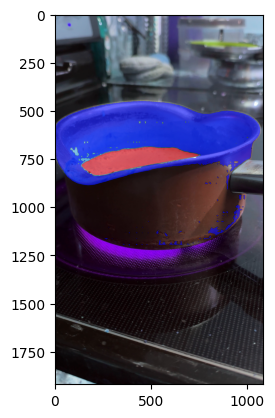

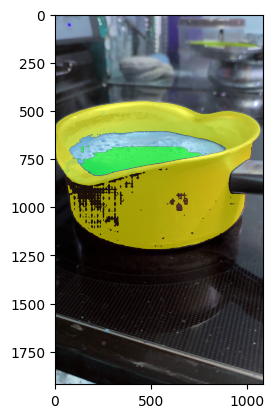

In [35]:
# sample first
frame_path = os.path.join("frames", f"frame-0000.jpg")
frame = cv2.imread(frame_path)

rim_mask,rim_scores,rim_logits = predict_masks_using_points(
    frame, (rim_point, tea_point), (1,0)
)
tea_mask,tea_scores,tea_logits = predict_masks_using_points(
    frame, (rim_point, tea_point), (0,1)
)

plt.imshow(frame)
show_mask(rim_mask, plt.gca(), Color.BLUE.to_array())
show_mask(tea_mask, plt.gca(), Color.RED.to_array())
plt.show()

frame_path = os.path.join("frames", f"frame-0010.jpg")
frame = cv2.imread(frame_path)
rim_mask,_,_ = predict_masks_using_logits(frame, (rim_point, tea_point), (1,0), rim_logits,rim_scores)
tea_mask,_,_ = predict_masks_using_logits(frame,(rim_point, tea_point), (0,1), tea_logits, tea_scores)

plt.imshow(frame)
show_mask(rim_mask, plt.gca(), Color.YELLOW.to_array())
show_mask(tea_mask, plt.gca(), Color.GREEN.to_array())
plt.show()



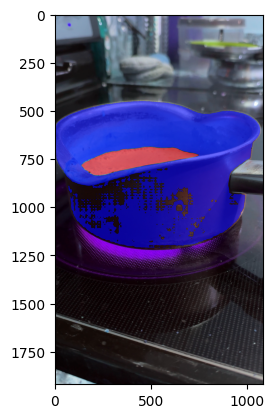

rim_highest: 451, tea_highest: 689
difference:  -238




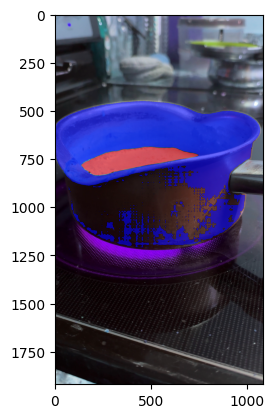

rim_highest: 451, tea_highest: 689
difference:  -238




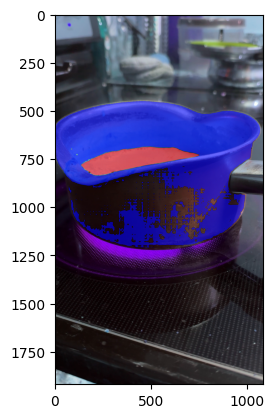

rim_highest: 451, tea_highest: 689
difference:  -238




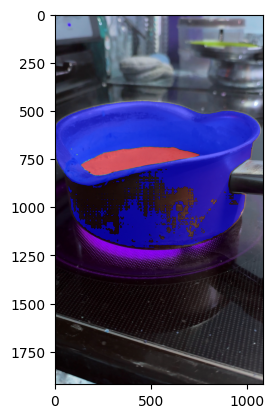

rim_highest: 451, tea_highest: 689
difference:  -238




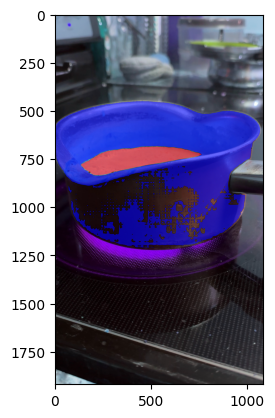

rim_highest: 451, tea_highest: 687
difference:  -236




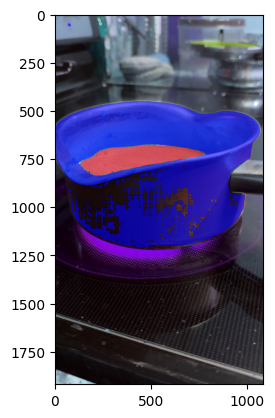

rim_highest: 451, tea_highest: 678
difference:  -227




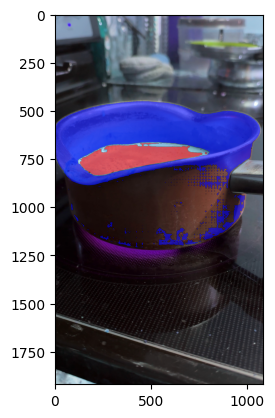

rim_highest: 451, tea_highest: 669
difference:  -218




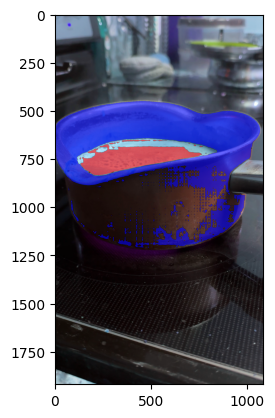

rim_highest: 451, tea_highest: 652
difference:  -201




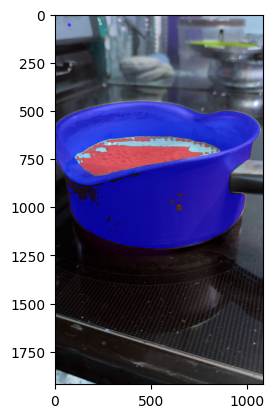

rim_highest: 452, tea_highest: 639
difference:  -187




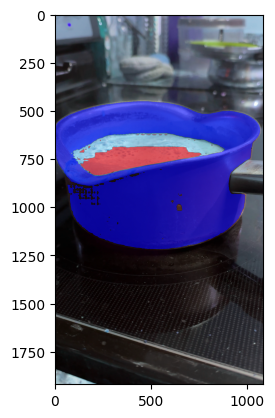

rim_highest: 452, tea_highest: 625
difference:  -173




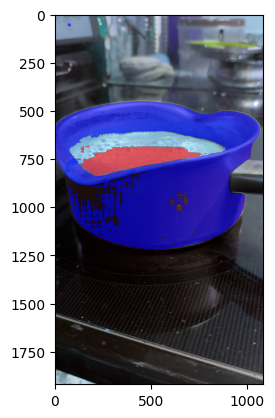

rim_highest: 452, tea_highest: 625
difference:  -173




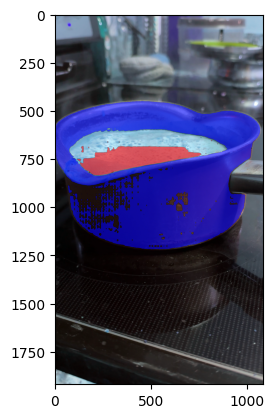

rim_highest: 451, tea_highest: 627
difference:  -176




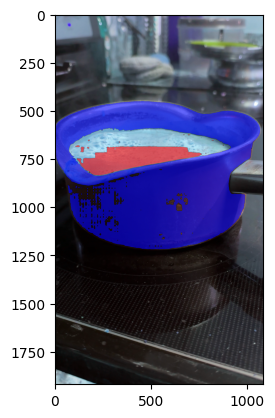

rim_highest: 451, tea_highest: 619
difference:  -168




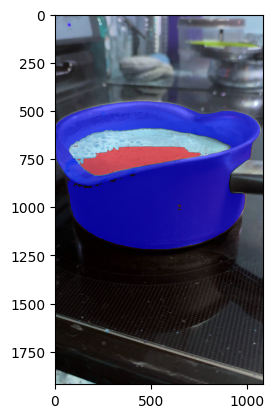

rim_highest: 451, tea_highest: 625
difference:  -174




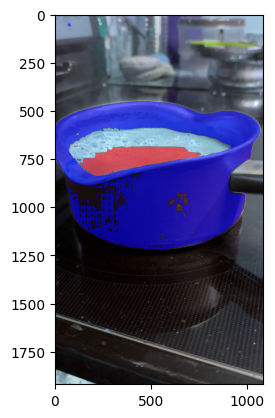

rim_highest: 451, tea_highest: 625
difference:  -174




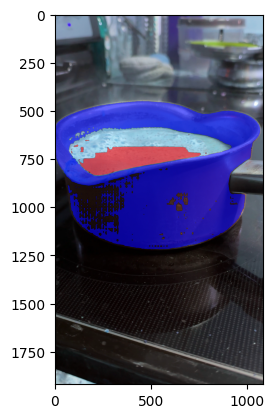

rim_highest: 451, tea_highest: 625
difference:  -174




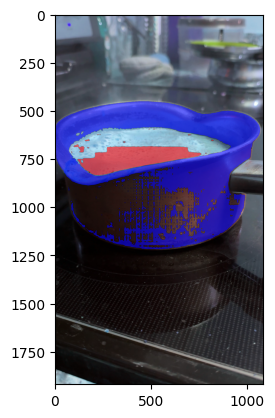

rim_highest: 452, tea_highest: 595
difference:  -143




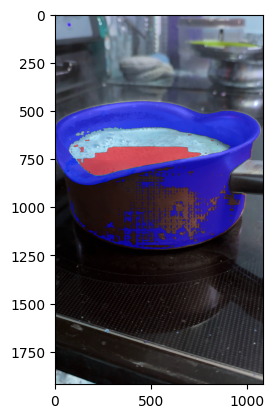

rim_highest: 451, tea_highest: 624
difference:  -173




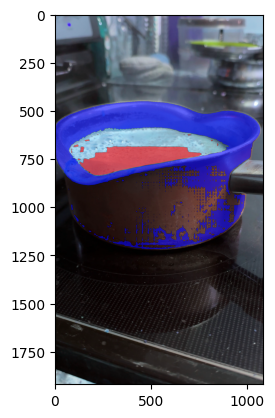

rim_highest: 452, tea_highest: 624
difference:  -172




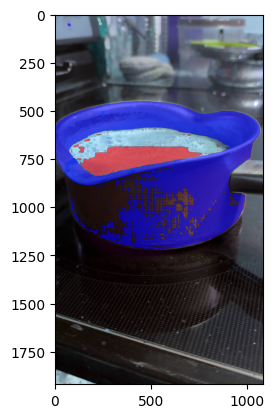

rim_highest: 451, tea_highest: 595
difference:  -144




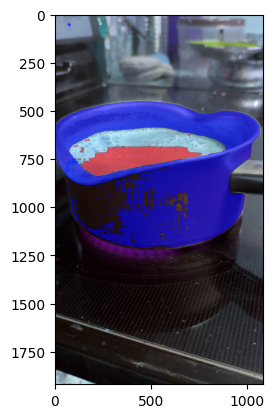

rim_highest: 451, tea_highest: 597
difference:  -146




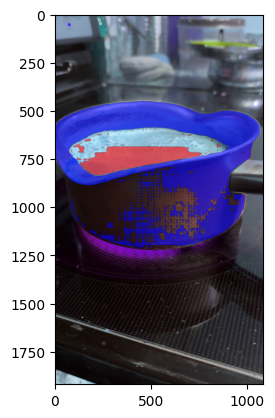

rim_highest: 451, tea_highest: 596
difference:  -145




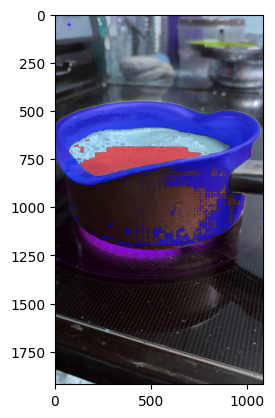

rim_highest: 451, tea_highest: 624
difference:  -173




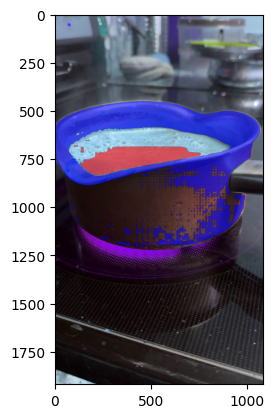

rim_highest: 451, tea_highest: 625
difference:  -174




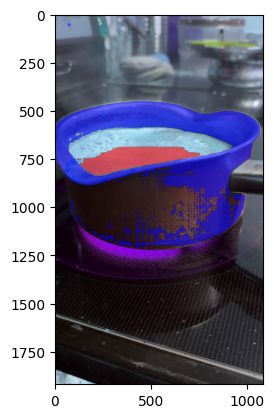

rim_highest: 451, tea_highest: 687
difference:  -236




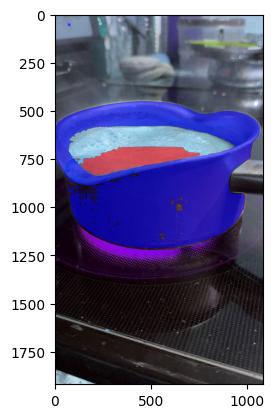

rim_highest: 451, tea_highest: 688
difference:  -237




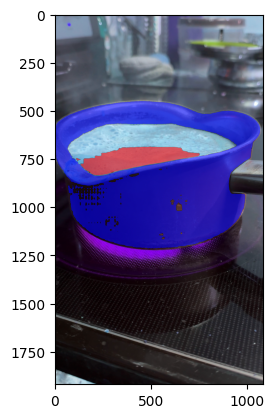

rim_highest: 451, tea_highest: 655
difference:  -204




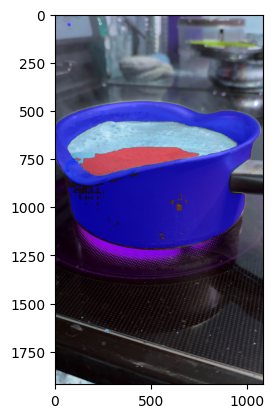

rim_highest: 451, tea_highest: 689
difference:  -238




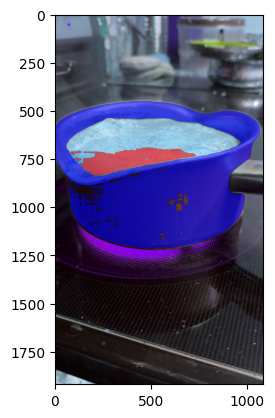

rim_highest: 451, tea_highest: 693
difference:  -242




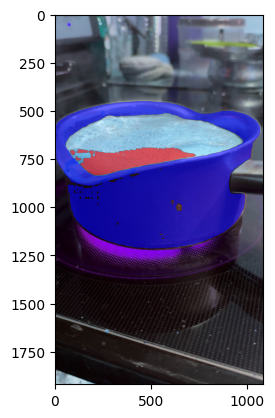

rim_highest: 451, tea_highest: 693
difference:  -242




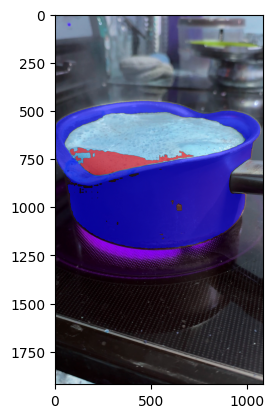

rim_highest: 451, tea_highest: 692
difference:  -241




In [36]:
for frame_number in range(FRAME_COUNT):
# for frame_number in range(15):
    frame_path = os.path.join("frames", f"frame-{frame_number:04d}.jpg")

    frame = cv2.imread(frame_path)

    rim_mask,_,_ = predict_masks_using_logits(frame, (rim_point, tea_point), (1,0), rim_logits,rim_scores)
    tea_mask,_,_ = predict_masks_using_logits(frame,(rim_point, tea_point), (0,1), tea_logits, tea_scores)

    plt.imshow(frame)
    show_mask(rim_mask, plt.gca(), Color.BLUE.to_array())
    show_mask(tea_mask, plt.gca(), Color.RED.to_array())
    plt.show()
    rim_highest = find_highest_point(rim_mask[0])
    tea_highest = find_highest_point(tea_mask[0])
    print(f"rim_highest: {rim_highest}, tea_highest: {tea_highest}")
    print("difference: ", rim_highest - tea_highest)
    print("\n")



In [ ]:
rim_highest = find_highest_point(rim_mask)
tea_highest = find_highest_point(tea_mask)
print(f"rim_highest: {rim_highest}, tea_highest: {tea_highest}")
print("difference: ", rim_highest - tea_highest)

